In [1]:
from math import exp, sqrt, pi
import numpy as np
from xxhash import xxh32

import matplotlib.pyplot as plt

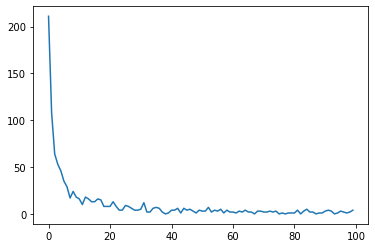

In [24]:
def zipf(a, d, n):
    p = np.arange(1, d+1)**(-a)
    p /= p.sum()
    return np.random.choice(np.arange(d), size=n, p=p)

def gauss(m, var, d, n):
    p = np.exp(-1*((np.arange(1, d+1) - m)**2)/(2*(var**2)))/(sqrt(2*pi) * var)
    p /= p.sum()
    return np.random.choice(np.arange(d), size=n, p=p)

d = 100
n = 1000

data = zipf(1.1, d, n)
# data = gauss(d/2, d/10, d, n)
freq = np.zeros(d)
for item in data:
    freq[item] += 1

plt.plot(freq)
plt.show()

In [30]:
dist_mat = np.zeros((d, d))
for i in range(d):
    for j in range(d):
        dist_mat[i][j] = abs(i - j)*100

In [16]:
# pi = np.zeros(d)
# for i in data:
#     pi[i] += 1
# pi /= pi.sum()
pi = np.full(d, 1/d)

In [5]:
alpha = 1
p_mat = np.exp(-alpha*dist_mat/2)
for i, _ in enumerate(p_mat):
    p_mat[i] /= p_mat[i].sum()
(pi*(dist_mat*p_mat).sum(axis=1)).sum()

1.1997505778892233e-17

In [6]:
from math import exp

epsilon = 55
p_mat_grr = np.full((d, d), 1/(exp(epsilon) + d - 1))
p_mat_grr[np.diag_indices_from(p_mat_grr)] = exp(epsilon)/(exp(epsilon) + d - 1)
(pi*(dist_mat*p_mat_grr).sum(axis=1)).sum()

1.3607823939998572e-16

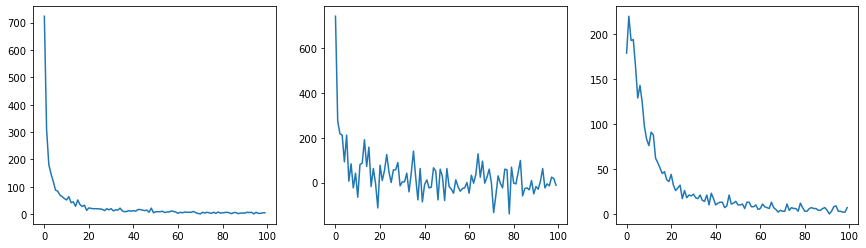

In [5]:
def EM(data, d, alpha, dist):
    p_mat = np.exp(-alpha*dist/2)
    for i, _ in enumerate(p_mat):
        p_mat[i] /= p_mat[i].sum()
    universe = np.arange(d)
    aggregated_data = np.zeros(d)
    for item in data:
        aggregated_data[np.random.choice(universe, p=p_mat[item])] += 1
    return aggregated_data

def OUE(data, d, epsilon):
    p = 1 - 1/2
    q = 1/(exp(epsilon)+1)
    aggregated_data = np.zeros(d)
    for i in range(len(data)):
        private_data = np.zeros(d)
        private_data[data[i]] = 1
        aggregated_data += np.where(private_data == 1, 
            np.random.binomial(1, p, d), 
            np.random.binomial(1, q, d))
    return (aggregated_data - len(data)*q)/(p - q)

def OLH(data, d, epsilon):
    g = int(round(exp(epsilon))) + 1
    p = exp(epsilon)/(exp(epsilon) + g - 1)
    q = 1/(exp(epsilon) + g - 1)
    aggregated_data = np.zeros(d)
    for i, item in enumerate(data):
        private_data = (xxh32(str(item), seed=i).intdigest() % g)
        if np.random.random_sample() > p - q:
            private_data = np.random.randint(0, g)
        for j in range(d):
            if private_data == (xxh32(str(j), seed=i).intdigest() % g):
                aggregated_data[j] +=  1
    return (g*aggregated_data - len(data))/(p*g - 1)

alpha = 0.1/30
epsilon = 1.6316026449203491

oue_freq = OUE(data, d, epsilon)
em_freq = EM(data, d, alpha, dist_mat)

plt.figure(figsize=(20, 4))
plt.subplot(141)
plt.plot(freq)
plt.subplot(142)
plt.plot(oue_freq)
plt.subplot(143)
plt.plot(em_freq)

plt.show()

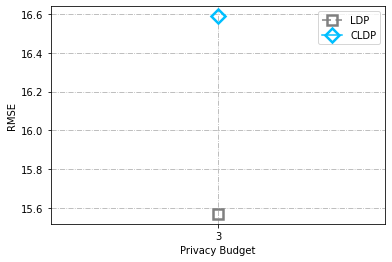

In [34]:
def MAE(freq, est_freq):
    return (abs(freq - est_freq)).mean()
def MRE(freq, est_freq):
    return (abs(np.dot(freq, np.arange(d)) - np.dot(est_freq, np.arange(d))))/(np.dot(freq, np.arange(d)) + np.finfo(np.float32).eps)
def jaccard_index(freq, est_freq, k):
    top_k = np.argpartition(-freq, k)[:k]
    est_top_k = np.argpartition(-est_freq, k)[:k]
    return len(np.intersect1d(top_k, est_top_k))/len(np.union1d(top_k, est_top_k))
def MSE(freq, est_freq):
    return (np.square(freq - est_freq)).mean()
def RMSE(freq, est_freq):
    return np.sqrt((np.square(freq - est_freq)).mean())

epsilon_range = [6.052]
alpha_range = [0.00333333]

ldp_util = []
cldp_util = []
for alpha, epsilon in zip(alpha_range, epsilon_range):
    oue_freq = OUE(data, d, epsilon)
    em_freq = EM(data, d, alpha, dist_mat)
    ldp_util.append(RMSE(oue_freq, freq))
    cldp_util.append(RMSE(em_freq, freq))
    # ldp_util.append(jaccard_index(oue_freq, freq, 10))
    # cldp_util.append(jaccard_index(em_freq, freq, 10))
x = epsilon_range
plt.plot(x, ldp_util, 's--', markersize=10, markerfacecolor='none', markeredgewidth=2.5, label='LDP', color='grey', dashes=[6, 3])
plt.plot(x, cldp_util, 'D-', markersize=10, markerfacecolor='none', markeredgewidth=2.5, label='CLDP', color='deepskyblue')
plt.xticks(x)
plt.xlabel('Privacy Budget')
plt.ylabel('RMSE')
plt.legend()
plt.grid(linestyle='-.')
plt.show()
